In [1]:
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def visualize_images_without_points(n_images: int, dataset, shape):
    """Visualize n_images images from the dataset."""
    images = dataset.sample(n_images)
    images = images.apply(lambda x: x.values.reshape(shape), axis=1).values

    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()


def visualize_images_with_points(n_images: int, dataset, shape, points):
    """Visualize n_images images from the dataset."""
    images = dataset.sample(n_images)
    points = points.loc[images.index]
    images = images.apply(lambda x: x.values.reshape(shape), axis=1).values

    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.plot(points.values[i][0::2], points.values[i][1::2], 'ro', markersize=2)

        ax.axis('off')

    plt.show()


def split_images_points(df):
    images = df['Image'].apply(lambda x: pd.Series(x.split(' ')))
    images = images.astype(np.float32)

    points = df.iloc[:, :-1]

    return images, points


def split_images_pixels(df):
    images = df[' pixels'].apply(lambda x: pd.Series(x.split(' ')))
    images = images.astype(np.float32)

    return images


In [2]:
facial_face_image_shape = (48, 48)
facial_face_points_shape = (96, 96)

original_facial_face_points = pd.read_csv('datasets/data.csv')
original_facial_face_images = pd.read_csv('datasets/icml_face_data.csv')

facial_emotions_targets = original_facial_face_images['emotion']
facial_emotions_images = split_images_pixels(original_facial_face_images)
original_facial_face_images[' pixels'] = facial_emotions_images.values.tolist()

facial_emotions_points_images, points = split_images_points(original_facial_face_points)
original_facial_face_points['Image'] = facial_emotions_points_images.values.tolist()

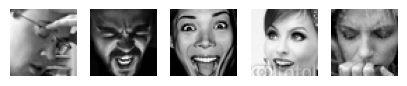

In [3]:
visualize_images_without_points(5, dataset=facial_emotions_images, shape=facial_face_image_shape)

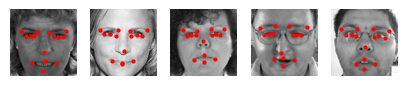

In [4]:
visualize_images_with_points(5, dataset=facial_emotions_points_images, shape=facial_face_points_shape, points=points)

In [5]:
def rotar_puntos(points, angle):
    # Cambia los puntos en el plano de manera que la rotación está justo en el origen
    # nuestra imagen es de 96*96 ,así que restamos 48
    points = points - 48

    # matriz de rotación
    # R = [ [cos(t), -sin(t)],[sin(t),cos(t)]
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    # rotar los puntos
    for i in range(0, len(points), 2):
        xy = np.array([points[i], points[i + 1]])
        xy_rot = R @ xy
        points[i], points[i + 1] = xy_rot

    # volver al origen del centro de rotación
    points = points + 48
    return points


def get_data_augmentation_flip(df):
    df_flip = df.copy()
    columns = df.columns[:-1]

    images = pd.Series(df_flip['Image'])
    # Horizontal Flip - Damos la vuelta a las imágenes entorno al eje y
    images = images.apply(lambda x: pd.Series(np.flip(x)))

    # dado que estamos volteando horizontalmente, los valores de la coordenada y serían los mismos
    # Solo cambiarían los valores de la coordenada x, todo lo que tenemos que hacer es restar nuestros valores iniciales de la coordenada x del ancho de la imagen (96)
    for i in range(len(columns)):
        if i % 2 == 0:
            df[columns[i]] = df[columns[i]].apply(lambda x: 96. - float(x))

    df_flip['Image'] = pd.Series(images.values.tolist())

    df_flip[columns] = rotar_puntos(df_flip.iloc[:, :-1].values, 180)

    return df_flip


facial_face_points_flipped = get_data_augmentation_flip(original_facial_face_points)
facial_face_points_flipped

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,56.997726,65.772992,59.578322,36.417925,56.352577,22.869654,56.030003,59.643429,58.610598,...,38.933197,34.804692,16.029835,67.385504,18.611008,52.687398,23.064541,52.869293,11.514226,"[90.0, 75.0, 70.0, 62.0, 49.0, 39.0, 34.0, 30...."
1,31.667064,61.029923,66.050723,62.551285,37.143830,60.725651,25.277277,59.812834,59.965277,61.638468,...,40.339064,39.578553,19.648000,60.877617,19.952340,49.315404,25.733447,50.532085,10.519830,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,30.942947,61.090358,65.096211,61.090358,36.588000,59.679032,25.015579,59.679032,58.321895,59.679032,...,42.461053,35.177053,22.985684,62.273684,23.268000,48.725053,25.808211,48.725053,17.340632,"[77.0, 78.0, 78.0, 71.0, 69.0, 70.0, 61.0, 56...."
3,30.774261,58.738226,63.976904,58.738226,35.996661,56.872821,23.685287,57.619033,58.381357,57.245885,...,41.833461,30.401113,23.296278,58.754504,21.804522,45.696835,25.908313,44.438817,17.731617,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,29.274699,56.378739,63.755190,57.957968,37.434110,56.378739,23.484074,56.115534,59.017620,56.905148,...,31.110479,35.328589,18.476761,64.808245,19.002699,51.037252,22.292613,51.772859,9.128834,"[176.0, 170.0, 140.0, 83.0, 46.0, 43.0, 37.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,28.819622,60.183627,62.760044,61.078068,36.652027,58.999096,23.332104,58.902400,56.595651,59.410056,...,35.934604,31.602390,22.751607,60.553569,21.985252,47.291374,19.239148,47.440388,18.664382,"[153.0, 161.0, 165.0, 167.0, 170.0, 173.0, 173..."
2136,30.275510,59.698980,70.622449,58.688776,37.469388,58.260204,21.551020,58.474490,62.448980,57.892857,...,33.527211,29.071879,16.770954,67.984623,14.848278,47.228024,14.183226,46.712729,13.128844,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14...."
2137,27.569134,57.348025,67.104143,58.382973,34.340650,55.899098,20.413208,55.780818,58.334882,56.912755,...,32.710424,27.135603,18.504177,73.986019,18.631005,46.819372,16.956870,48.823261,6.455478,"[75.0, 51.0, 39.0, 36.0, 38.0, 38.0, 39.0, 39...."
2138,31.847820,65.308408,68.999102,55.131918,39.494376,61.873037,22.563224,67.443665,61.253878,55.493061,...,36.264201,22.269257,25.726114,57.222857,15.315714,37.957143,16.698571,37.388914,15.644457,"[57.0, 177.0, 179.0, 185.0, 187.0, 189.0, 191...."


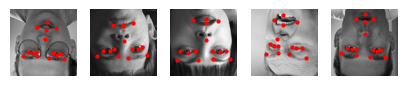

In [6]:
points = facial_face_points_flipped.iloc[:, :-1]
images = facial_face_points_flipped['Image'].apply(lambda x: pd.Series(x))

visualize_images_with_points(5, dataset=images, shape=facial_face_points_shape, points=points)

In [7]:
from scipy import ndimage, misc


def get_data_augmentation_rotate(df_to_rotate, angles):
    def rotate_images(element, rotation_angles: list):
        rotation_angle = np.random.choice(rotation_angles, 1)[0]

        image = element['Image']
        rotated_image = np.array(image).reshape(facial_face_points_shape)
        rotated_image = np.array(ndimage.rotate(rotated_image, -rotation_angle, reshape=False)).astype(np.float32)

        rotated_points = rotar_puntos(element[:-1].values, rotation_angle)
        element.loc[element[:-1].index.values] = rotated_points
        element['Image'] = rotated_image.reshape(-1).tolist()

        return element

    new_df_rotations = df_to_rotate.apply(rotate_images, rotation_angles=angles, axis=1)
    df_rotations = pd.concat([df_to_rotate, new_df_rotations])

    print(f'Rotated {len(df_rotations)} images')

    return df_rotations


angles_to_rotate = [-120, -80, -50, -10, 10, 15, 25, 50, 80, 90, 120, 150, 165]

facial_face_points_rotated = get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate)
facial_face_points_rotated = get_data_augmentation_rotate(facial_face_points_rotated, angles_to_rotate)

facial_face_points_rotated

Rotated 4280 images
Rotated 8560 images


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,39.002274,65.772992,36.421678,36.417925,39.647423,22.869654,39.969997,59.643429,37.389402,...,57.066803,34.804692,79.970165,67.385504,77.388992,52.687398,72.935459,52.869293,84.485774,"[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 239..."
1,31.667064,34.970077,66.050723,33.448715,37.143830,35.274349,25.277277,36.187166,59.965277,34.361532,...,55.660936,39.578553,76.352000,60.877617,76.047660,49.315404,70.266553,50.532085,85.480170,"[219.0, 215.0, 204.0, 196.0, 204.0, 211.0, 212..."
2,30.942947,34.909642,65.096211,34.909642,36.588000,36.320968,25.015579,36.320968,58.321895,36.320968,...,53.538947,35.177053,73.014316,62.273684,72.732000,48.725053,70.191789,48.725053,78.659368,"[144.0, 142.0, 159.0, 180.0, 188.0, 188.0, 184..."
3,30.774261,37.261774,63.976904,37.261774,35.996661,39.127179,23.685287,38.380967,58.381357,38.754115,...,54.166539,30.401113,72.703722,58.754504,74.195478,45.696835,70.091687,44.438817,78.268383,"[193.0, 192.0, 193.0, 194.0, 194.0, 194.0, 193..."
4,29.274699,39.621261,63.755190,38.042032,37.434110,39.621261,23.484074,39.884466,59.017620,39.094852,...,64.889521,35.328589,77.523239,64.808245,76.997301,51.037252,73.707387,51.772859,86.871166,"[147.0, 148.0, 160.0, 196.0, 215.0, 214.0, 216..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,50.995710,70.524506,28.494045,45.099571,46.868540,63.763135,55.504495,73.904633,33.734212,48.749592,...,38.563344,77.881572,44.331943,59.859175,21.661451,70.487587,30.055719,70.832099,29.572116,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2136,33.907376,32.112218,72.618066,43.530556,40.483746,35.363881,25.163245,31.036920,64.517102,42.183905,...,60.517460,21.634168,73.265984,58.723367,85.194505,38.501904,80.464693,37.731272,81.349780,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2137,69.659746,42.028295,40.039424,68.233725,63.541111,45.270999,74.134122,36.228005,45.812030,61.470701,...,32.868588,45.023506,11.993512,9.215529,42.205536,28.950274,23.460690,20.665041,16.704232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2138,68.081553,60.538147,29.562301,60.323872,59.806408,59.198907,77.602429,60.197617,37.137084,58.668097,...,35.091521,67.089083,19.825472,30.632088,18.816455,49.599249,15.165859,49.875291,14.000594,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
def set_random_brightness(dataframe_to_brightness):
    def change_image_brightness(element):
        brightness = np.random.uniform(0, 2)

        image = np.array(element['Image']).reshape(facial_face_points_shape)

        element['Image'] = np.array(image * brightness).reshape(-1).astype(float).tolist()

        return element

    new_dataframe = dataframe_to_brightness.apply(change_image_brightness, axis=1)

    return pd.concat([dataframe_to_brightness, new_dataframe])


facial_face_points_with_brightness = set_random_brightness(original_facial_face_points)
facial_face_points_with_brightness = set_random_brightness(facial_face_points_with_brightness)

facial_face_points_with_brightness

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,39.002274,65.772992,36.421678,36.417925,39.647423,22.869654,39.969997,59.643429,37.389402,...,57.066803,34.804692,79.970165,67.385504,77.388992,52.687398,72.935459,52.869293,84.485774,"[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 239..."
1,31.667064,34.970077,66.050723,33.448715,37.143830,35.274349,25.277277,36.187166,59.965277,34.361532,...,55.660936,39.578553,76.352000,60.877617,76.047660,49.315404,70.266553,50.532085,85.480170,"[219.0, 215.0, 204.0, 196.0, 204.0, 211.0, 212..."
2,30.942947,34.909642,65.096211,34.909642,36.588000,36.320968,25.015579,36.320968,58.321895,36.320968,...,53.538947,35.177053,73.014316,62.273684,72.732000,48.725053,70.191789,48.725053,78.659368,"[144.0, 142.0, 159.0, 180.0, 188.0, 188.0, 184..."
3,30.774261,37.261774,63.976904,37.261774,35.996661,39.127179,23.685287,38.380967,58.381357,38.754115,...,54.166539,30.401113,72.703722,58.754504,74.195478,45.696835,70.091687,44.438817,78.268383,"[193.0, 192.0, 193.0, 194.0, 194.0, 194.0, 193..."
4,29.274699,39.621261,63.755190,38.042032,37.434110,39.621261,23.484074,39.884466,59.017620,39.094852,...,64.889521,35.328589,77.523239,64.808245,76.997301,51.037252,73.707387,51.772859,86.871166,"[147.0, 148.0, 160.0, 196.0, 215.0, 214.0, 216..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,28.819622,35.816373,62.760044,34.921932,36.652027,37.000904,23.332104,37.097600,56.595651,36.589944,...,60.065396,31.602390,73.248393,60.553569,74.014748,47.291374,76.760852,47.440388,77.335618,"[264.44907271730256, 264.44907271730256, 264.4..."
2136,30.275510,36.301020,70.622449,37.311224,37.469388,37.739796,21.551020,37.525510,62.448980,38.107143,...,62.472789,29.071879,79.229046,67.984623,81.151722,47.228024,81.816774,46.712729,82.871156,"[22.571761677676797, 22.571761677676797, 22.57..."
2137,27.569134,38.651975,67.104143,37.617027,34.340650,40.100902,20.413208,40.219182,58.334882,39.087245,...,63.289576,27.135603,77.495823,73.986019,77.368995,46.819372,79.043130,48.823261,89.544522,"[60.886403877898715, 78.56310177793384, 92.311..."
2138,31.847820,30.691592,68.999102,40.868082,39.494376,34.126963,22.563224,28.556335,61.253878,40.506939,...,59.735799,22.269257,70.273886,57.222857,80.684286,37.957143,79.301429,37.388914,80.355543,"[2.1212135725665355, 0.30303051036664796, 1.51..."


In [9]:

augmented_facial_face_points = [original_facial_face_points, facial_face_points_flipped, facial_face_points_rotated, facial_face_points_with_brightness]

augmented_facial_face_points = pd.concat(augmented_facial_face_points, ignore_index=True, axis=0)

print(f'Augmented dataset has {len(augmented_facial_face_points)} images')

Augmented dataset has 21400 images


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_augmented_facial_face_points = augmented_facial_face_points.copy()

points_columns = normalized_augmented_facial_face_points.columns[:-1]

normalized_augmented_facial_face_points['Image'] = normalized_augmented_facial_face_points['Image'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).reshape(-1).astype(np.float32))

normalized_augmented_facial_face_points

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,39.002274,65.772992,36.421678,36.417925,39.647423,22.869654,39.969997,59.643429,37.389402,...,57.066803,34.804692,79.970165,67.385504,77.388992,52.687398,72.935459,52.869293,84.485774,"[0.9402391, 0.93227094, 0.936255, 0.9402391, 0..."
1,31.667064,34.970077,66.050723,33.448715,37.143830,35.274349,25.277277,36.187166,59.965277,34.361532,...,55.660936,39.578553,76.352000,60.877617,76.047660,49.315404,70.266553,50.532085,85.480170,"[0.85882354, 0.84313726, 0.8, 0.76862746, 0.8,..."
2,30.942947,34.909642,65.096211,34.909642,36.588000,36.320968,25.015579,36.320968,58.321895,36.320968,...,53.538947,35.177053,73.014316,62.273684,72.732000,48.725053,70.191789,48.725053,78.659368,"[0.55785125, 0.5495868, 0.6198347, 0.7066116, ..."
3,30.774261,37.261774,63.976904,37.261774,35.996661,39.127179,23.685287,38.380967,58.381357,38.754115,...,54.166539,30.401113,72.703722,58.754504,74.195478,45.696835,70.091687,44.438817,78.268383,"[0.89767444, 0.89302325, 0.89767444, 0.9023256..."
4,29.274699,39.621261,63.755190,38.042032,37.434110,39.621261,23.484074,39.884466,59.017620,39.094852,...,64.889521,35.328589,77.523239,64.808245,76.997301,51.037252,73.707387,51.772859,86.871166,"[0.5714286, 0.57539684, 0.6230159, 0.765873, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21395,28.819622,35.816373,62.760044,34.921932,36.652027,37.000904,23.332104,37.097600,56.595651,36.589944,...,60.065396,31.602390,73.248393,60.553569,74.014748,47.291374,76.760852,47.440388,77.335618,"[0.84976524, 0.84976524, 0.84976524, 0.8450704..."
21396,30.275510,36.301020,70.622449,37.311224,37.469388,37.739796,21.551020,37.525510,62.448980,38.107143,...,62.472789,29.071879,79.229046,67.984623,81.151722,47.228024,81.816774,46.712729,82.871156,"[0.10497238, 0.10497238, 0.10497238, 0.0994475..."
21397,27.569134,38.651975,67.104143,37.617027,34.340650,40.100902,20.413208,40.219182,58.334882,39.087245,...,63.289576,27.135603,77.495823,73.986019,77.368995,46.819372,79.043130,48.823261,89.544522,"[0.080168776, 0.11814346, 0.14767933, 0.080168..."
21398,31.847820,30.691592,68.999102,40.868082,39.494376,34.126963,22.563224,28.556335,61.253878,40.506939,...,59.735799,22.269257,70.273886,57.222857,80.684286,37.957143,79.301429,37.388914,80.355543,"[0.029166667, 0.004166667, 0.020833334, 0.0041..."


In [11]:
# suffle pandas dataframe
normalized_augmented_facial_face_points = normalized_augmented_facial_face_points.sample(frac=1).reset_index(drop=True)
normalized_augmented_facial_face_points

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,34.049692,35.633804,70.703573,40.155323,42.116282,37.712221,26.155549,35.807947,62.970004,40.807232,...,58.925670,30.824271,73.032845,67.284810,76.596850,49.157102,74.135379,49.131461,80.391618,"[0.17370892, 0.16431925, 0.17370892, 0.2018779..."
1,30.538857,32.824000,71.262286,30.752000,39.003429,32.787429,21.811429,33.792000,62.327429,31.944000,...,53.656619,33.177143,72.387755,71.601633,71.187755,52.205714,71.873469,52.058776,78.485714,"[0.25625, 0.225, 0.2, 0.21875, 0.21875, 0.2125..."
2,30.780800,37.165867,65.341867,37.165867,36.978133,37.642133,24.821867,38.118933,59.144533,37.880533,...,54.803733,32.687467,76.493333,65.103467,76.017067,49.648000,72.201067,49.133867,81.022400,"[0.41489363, 0.5053192, 0.5425532, 0.5212766, ..."
3,31.088123,32.989414,65.839202,43.029980,36.431124,35.235906,24.882110,32.677776,60.317750,41.795536,...,52.433986,26.687985,69.778625,55.203606,78.198101,43.266728,67.484630,39.071783,82.396770,"[0.035350457, 0.035350457, 0.035350457, 0.0353..."
4,29.496774,36.190839,68.723613,38.085677,37.266581,36.759484,18.126968,36.001161,59.817290,38.275355,...,59.689161,24.190839,71.817290,69.102581,75.228000,47.878452,70.869677,47.120516,87.356129,"[0.038961038, 0.017316017, 0.012987013, 0.0129..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21395,26.249796,34.080816,61.955918,35.932245,34.757551,34.080816,19.835918,34.389388,57.746122,36.306939,...,57.951020,35.757714,79.396299,66.799020,79.667320,52.599837,79.406095,52.995918,82.306667,"[0.13872832, 0.14450867, 0.15028901, 0.1560693..."
21396,31.629793,33.559327,65.517976,33.776718,36.909714,35.136653,23.583347,34.243265,57.383184,34.888490,...,57.259364,32.325508,69.300201,63.722967,70.782990,47.135630,70.588038,46.980201,77.049426,"[0.015748031, 0.011811024, 0.007874016, 0.0078..."
21397,53.086908,26.372828,65.367896,58.975676,55.135793,35.558415,47.498936,19.181123,60.965537,51.746867,...,52.596640,18.807257,43.904571,29.762646,71.453408,27.790821,56.903703,18.774085,60.420731,"[0.12737508, 0.12737508, 0.12737508, 0.1273750..."
21398,27.097946,37.320000,65.942919,35.580973,33.185514,37.899892,21.300324,38.769730,58.985514,37.320000,...,52.393946,30.286703,70.366703,65.073081,69.497514,47.969514,66.308757,47.679568,81.382703,"[0.735, 0.745, 0.75, 0.74, 0.75, 0.75, 0.755, ..."


In [14]:
import json
print(normalized_augmented_facial_face_points['Image'].tolist())
normalized_augmented_facial_face_points['Image'] = normalized_augmented_facial_face_points['Image'].apply(lambda x: json.dumps(x.tolist()))
normalized_augmented_facial_face_points.to_csv('datasets/augmented_data.csv', sep=':', index=False)

KeyboardInterrupt: 

In [ ]:
from ast import literal_eval

augmented_data = pd.read_csv('datasets/augmented_data.csv', converters={'Image': lambda x: print(x)}, sep=':')
augmented_data

In [ ]:
dataframe_shape = normalized_augmented_facial_face_points.shape
dataframe_range = range(dataframe_shape[0]-1000,dataframe_shape[0])
print(dataframe_range)
images = normalized_augmented_facial_face_points.loc[dataframe_range, 'Image'].apply(lambda x: pd.Series(x))

visualize_images_with_points(5, dataset=images, shape=facial_face_points_shape, points=normalized_augmented_facial_face_points.iloc[dataframe_range, :-1])